# Class Size Report (2016-2017)

We will also use data from the [Kaggle 2016-2017 NYC Class Size Report](https://www.kaggle.com/marcomarchetti/20162017-nyc-class-size-report)

This dataset includes the following information:
- number of students
- number of classes
- average class size
- minimum class size
- maximum class size

by School x Program Type x Department x Subject

It also contains a school-wide pupil-to-teacher ratio

In [ ]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# set default options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

%matplotlib inline

In [ ]:
# load data
raw_class_size_df = pd.read_csv('February2017_Avg_ClassSize_School_all.csv')

In [3]:
# look at top-level stats on the dataset
raw_class_size_df.info()


## Observation:

Since almost a third of our data is missing Department and Subject-level data, we will aggregate number of students and classes at the school level. We will recalculate average class size from those numbers, rather than averaging the provided averages.

In [4]:
# preview the data
raw_class_size_df

,DBN,School Name,Grade Level,Program Type,Number of Students,Number of Classes,Average Class Size,Minimum Class Size,Maximum Class Size,Department,Subject,School Pupil-Teacher Ratio
0,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,Gen Ed,73,3,24.3,14.0,30.0,English,MS English Core,9.0
1,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,Gen Ed,73,3,24.3,14.0,30.0,Math,MS Math Core,9.0
2,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,Gen Ed,73,3,24.3,14.0,30.0,Science,MS Science Core,9.0
3,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,Gen Ed,73,3,24.3,14.0,30.0,Social Studies,MS Social Studies Core,9.0
4,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,ICT,85,3,28.3,24.0,31.0,English,MS English Core,9.0
5,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,ICT,85,3,28.3,24.0,31.0,Math,MS Math Core,9.0
6,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,ICT,85,3,28.3,24.0,31.0,Science,MS Science Core,9.0
7,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,ICT,85,3,28.3,24.0,31.0,Social Studies,MS Social Studies Core,9.0
8,01M140,P.S. 140 NATHAN STRAUS,MS Core,Accelerated,13,1,13.0,13.0,13.0,Science,MS Science Other,12.6
9,01M140,P.S. 140 NATHAN STRAUS,MS Core,Gen Ed,82,3,27.3,26.0,28.0,English,MS English Core,12.6


In [5]:
# look at a specific school to get a sense of the data
raw_class_size_df[raw_class_size_df.DBN == '01M034']

,DBN,School Name,Grade Level,Program Type,Number of Students,Number of Classes,Average Class Size,Minimum Class Size,Maximum Class Size,Department,Subject,School Pupil-Teacher Ratio
0,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,Gen Ed,73,3,24.3,14.0,30.0,English,MS English Core,9.0
1,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,Gen Ed,73,3,24.3,14.0,30.0,Math,MS Math Core,9.0
2,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,Gen Ed,73,3,24.3,14.0,30.0,Science,MS Science Core,9.0
3,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,Gen Ed,73,3,24.3,14.0,30.0,Social Studies,MS Social Studies Core,9.0
4,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,ICT,85,3,28.3,24.0,31.0,English,MS English Core,9.0
5,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,ICT,85,3,28.3,24.0,31.0,Math,MS Math Core,9.0
6,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,ICT,85,3,28.3,24.0,31.0,Science,MS Science Core,9.0
7,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,ICT,85,3,28.3,24.0,31.0,Social Studies,MS Social Studies Core,9.0
19454,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,K,Gen Ed,10,1,10.0,10.0,10.0,NaN,NaN,9.0
19455,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,K,ICT,11,1,11.0,11.0,11.0,NaN,NaN,9.0


## Observation:

Some rows contain data per deparment-subject.  These rows are specified by Grade Level = 'MS Core".  Other rows for the same school contain data per grade level, but without subject.  These rows are specified by Grade Level in [K...8]

In [6]:
# count of non-null observations for all columns, by grade level
raw_class_size_df.groupby(['Grade Level']).count()

,DBN,School Name,Program Type,Number of Students,Number of Classes,Average Class Size,Minimum Class Size,Maximum Class Size,Department,Subject,School Pupil-Teacher Ratio
Grade Level,,,,,,,,,,,
1,1446,1446,1446,1446,1446,1446,1446,1446,0,0,1446
2,1424,1424,1424,1424,1424,1424,1424,1424,0,0,1424
3,1410,1410,1410,1410,1410,1410,1410,1410,0,0,1410
4,1378,1378,1378,1378,1378,1378,1378,1378,0,0,1378
5,1347,1347,1347,1347,1347,1347,1347,1347,0,0,1347
6,905,905,905,905,905,905,905,905,0,0,905
7,869,869,869,869,869,869,869,869,0,0,869
8,859,859,859,859,859,859,859,859,0,0,859
HS Core,13316,13316,13316,13316,13316,13316,13316,13316,13316,13316,13316


In [7]:
# mean value for all numeric columns, by grade level
raw_class_size_df.groupby(['Grade Level']).mean()

,Number of Students,Number of Classes,Average Class Size,Minimum Class Size,Maximum Class Size,School Pupil-Teacher Ratio
Grade Level,,,,,,
1,47.429461,1.933610,24.340387,23.575380,25.035961,14.054633
2,48.210674,1.920646,25.009480,24.273876,25.703652,14.067135
3,48.008511,1.888652,25.217518,24.465957,25.944681,14.085532
4,49.701742,1.901306,25.946154,25.140784,26.691582,14.150508
5,48.359317,1.851522,25.861915,25.111359,26.541203,14.112398
6,69.806630,2.608840,25.890939,24.577901,26.955801,13.558785
7,70.703107,2.615650,25.998849,24.761795,27.002301,13.503797
8,73.164144,2.674040,26.355763,25.052386,27.431898,13.464028
HS Core,96.219661,3.760964,24.036971,20.362797,27.151697,14.604896


In [8]:
# DEBUGGING / CROSS-CHECKING LOGIC

# Examine data for a few specific schools

# this school reported both ways (by class level and separately by grade)
# numbers appear pretty consistent between the two reporting approaches
# raw_class_size_df[raw_class_size_df.DBN == '01M034']

# this school reported both ways, but numbers aren't consistent between them
# raw_class_size_df[raw_class_size_df.DBN == '01M539']
# raw_class_size_df[raw_class_size_df.DBN == '31R024']

# this school reported only by program type
# raw_class_size_df[raw_class_size_df.DBN == '31R044']

## Observations:

Department data is only listed for "MS Core" and "HS Core" grade levels.  Based on small class sizes, I suspect that "K-8 SC" may be special ed classes.

The original dataset has minimal documentation, except to say that it's the merger of 3 datasets: "K-8 Avg, MS HS Avg, PTR".  PTR must mean pupil-teacher ratio, and appears to have been cleanly joined to all rows, presumably based on DBN.  Based on that description and the above observations re: department/subject columns, I'm going to assume that the "MS HS Avg" dataset is represented here are "MS Core" and "HS Core" grade level.   I'll assume that the individual grade levels [K, 1, ... 8] and "K-8 SC" come from the "K-8 Avg" dataset.  Spot checking a few middle school DBN's shows that there are records of both types in our dataset, but I'm not able to reconcile the numbers.  

**As a result, I will stick with only the "MS HS Avg" dataset, with its additional PTR joined column.**  Since we only care about middle school for PASSNYC purposes, we only need to keep Grade Level == 'MS Core' (ie. filter out Grade Level == 'HS Core').

In [9]:
# remove all except the 'MS Core' data
class_size_df = raw_class_size_df[raw_class_size_df['Grade Level'] == 'MS Core']

# we expect to still have multiple rows per school (because of program X department X subject variations)
class_size_df.info()

# we don't need to read too much into these stats, but worth taking a quick look
class_size_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6105 entries, 0 to 19401
Data columns (total 12 columns):
DBN                           6105 non-null object
School Name                   6105 non-null object
Grade Level                   6105 non-null object
Program Type                  6105 non-null object
Number of Students            6105 non-null int64
Number of Classes             6105 non-null int64
Average Class Size            6105 non-null float64
Minimum Class Size            6105 non-null float64
Maximum Class Size            6105 non-null float64
Department                    6105 non-null object
Subject                       6105 non-null object
School Pupil-Teacher Ratio    6105 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 620.0+ KB


,Number of Students,Number of Classes,Average Class Size,Minimum Class Size,Maximum Class Size,School Pupil-Teacher Ratio
count,6105.000000,6105.000000,6105.000000,6105.000000,6105.000000,6105.000000
mean,144.991974,6.013759,22.275987,18.800983,26.137592,13.635954
std,196.057113,7.949246,8.252317,9.140103,11.417523,2.855117
min,2.000000,1.000000,2.000000,2.000000,2.000000,4.100000
25%,35.000000,2.000000,15.200000,10.000000,19.000000,11.800000
50%,82.000000,4.000000,24.600000,20.000000,28.000000,13.700000
75%,168.000000,7.000000,28.500000,26.000000,31.000000,15.400000
max,2105.000000,255.000000,80.000000,93.000000,100.000000,23.900000


In [10]:
# taking another quick look at the dataframe
class_size_df

,DBN,School Name,Grade Level,Program Type,Number of Students,Number of Classes,Average Class Size,Minimum Class Size,Maximum Class Size,Department,Subject,School Pupil-Teacher Ratio
0,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,Gen Ed,73,3,24.3,14.0,30.0,English,MS English Core,9.0
1,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,Gen Ed,73,3,24.3,14.0,30.0,Math,MS Math Core,9.0
2,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,Gen Ed,73,3,24.3,14.0,30.0,Science,MS Science Core,9.0
3,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,Gen Ed,73,3,24.3,14.0,30.0,Social Studies,MS Social Studies Core,9.0
4,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,ICT,85,3,28.3,24.0,31.0,English,MS English Core,9.0
5,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,ICT,85,3,28.3,24.0,31.0,Math,MS Math Core,9.0
6,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,ICT,85,3,28.3,24.0,31.0,Science,MS Science Core,9.0
7,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,MS Core,ICT,85,3,28.3,24.0,31.0,Social Studies,MS Social Studies Core,9.0
8,01M140,P.S. 140 NATHAN STRAUS,MS Core,Accelerated,13,1,13.0,13.0,13.0,Science,MS Science Other,12.6
9,01M140,P.S. 140 NATHAN STRAUS,MS Core,Gen Ed,82,3,27.3,26.0,28.0,English,MS English Core,12.6


Next, we temporarily pull out the pupil-teacher ratios into a separate dataframe.  We do this because we'll need to do a groupby and pivot on the remaining columns in order to flatten the department X subject stats into columns.  Afterwards we will rejoin this info.

Note: all pupil-teacher ratio values for each school are identical, so the mean is just a convenient way of grabbing that value.  It's not actually averaging a wider distribution.  For example: `mean(9.0 x n records) = (9.0 x n) / n = 9.0`

In [11]:
# split out school-level pupil-teacher ratios (one row per school)
ratio_df = class_size_df.groupby(['DBN'])['School Pupil-Teacher Ratio'].mean()
ratio_df.describe()

count    494.000000
mean      13.486235
std        2.881326
min        4.100000
25%       11.700000
50%       13.500000
75%       15.300000
max       23.900000
Name: School Pupil-Teacher Ratio, dtype: float64

In [21]:
# sum students and num classes by school x department (combining across different program types and subjects)
class_stats_df = class_size_df.groupby(['DBN','Department'])['Number of Students','Number of Classes'].sum()
class_stats_df

Number of Students  Number of Classes
DBN    Department                                           
01M034 English                        158                  6
       Math                           158                  6
       Science                        158                  6
       Social Studies                 158                  6
01M140 English                        213                  9
       Math                           186                  9
       Science                        182                  9
       Social Studies                 186                  8
01M184 English                        254                 10
       Math                           254                 10
       Science                        254                 10
       Social Studies                 254                 10
01M188 English                         83                  2
       Math                           179                  7
       Science                        181                  8
01M301 English                        127                  6
       Math                           127                  6
       Science                        127                  6
       Social Studies                 127                  6
01M332 English                        239                 13
       Math                           458                 24
       Science                        229                 11
01M378 English                        282                 14
       Math                           335                 16
       Science                        282                 14
       Social Studies                 268                 13
01M450 English                        306                 13
       Math                           309                 16
       Science                        300                 13
       Social Studies                 300                 15
01M539 English                        412                 15
       Math                           392                 15
       Science                        412                 15
       Social Studies                 412                 15
01M839 Math                           402                 13
       Science                        373                 12
02M104 English                       1750                 64
       Math                          1138                 41
       Science                       1138                 41
       Social Studies                1173                 43
02M114 English                        443                 15
       Math                           508                 21
       Science                        443                 13
       Social Studies                 443                 15
02M126 English                        462                 16
       Math                           570                 20
       Science                        344                 12
       Social Studies                 344                 12
02M131 English                        458                 24
       Math                           476                 20
       Science                        444                 19
       Social Studies                 444                 20
02M167 English                       1349                 44
       Math                          1349                 44
       Science                       1349                 44
       Social Studies                1349                 44
02M177 English                        211                  8
       Math                           211                  8
       Science                        289                 11
       Social Studies                 211                  8
02M217 English                         61                  3
       Math                            61                  3
       Science                         72                  4
       Social Studies                  61                 

In [22]:
# derive an average class size column
class_stats_df['Average Class Size'] = class_stats_df['Number of Students'] / class_stats_df['Number of Classes']
class_stats_df

Number of Students  Number of Classes  \
DBN    Department                                              
01M034 English                        158                  6   
       Math                           158                  6   
       Science                        158                  6   
       Social Studies                 158                  6   
01M140 English                        213                  9   
       Math                           186                  9   
       Science                        182                  9   
       Social Studies                 186                  8   
01M184 English                        254                 10   
       Math                           254                 10   
       Science                        254                 10   
       Social Studies                 254                 10   
01M188 English                         83                  2   
       Math                           179                  7   
       Science                        181                  8   
01M301 English                        127                  6   
       Math                           127                  6   
       Science                        127                  6   
       Social Studies                 127                  6   
01M332 English                        239                 13   
       Math                           458                 24   
       Science                        229                 11   
01M378 English                        282                 14   
       Math                           335                 16   
       Science                        282                 14   
       Social Studies                 268                 13   
01M450 English                        306                 13   
       Math                           309                 16   
       Science                        300                 13   
       Social Studies                 300                 15   
01M539 English                        412                 15   
       Math                           392                 15   
       Science                        412                 15   
       Social Studies                 412                 15   
01M839 Math                           402                 13   
       Science                        373                 12   
02M104 English                       1750                 64   
       Math                          1138                 41   
       Science                       1138                 41   
       Social Studies                1173                 43   
02M114 English                        443                 15   
       Math                           508                 21   
       Science                        443                 13   
       Social Studies                 443                 15   
02M126 English                        462                 16   
       Math                           570                 20   
       Science                        344                 12   
       Social Studies                 344                 12   
02M131 English                        458                 24   
       Math                           476                 20   
       Science                        444                 19   
       Social Studies                 444                 20   
02M167 English                       1349                 44   
       Math                          1349                 44   
       Science                       1349                 44   
       Social Studies                1349                 44   
02M177 English                        211                  8   
       Math                           211                  8   
       Science                        289                 11   
       Social Studies                 211                  8   
02M217 English                         61              

In [24]:
# reindex so we can pivot
class_stats_df = class_stats_df.reset_index()

# pivot to get department x stats into columns, not rows
class_stats_w_avg_df = class_stats_df.pivot(index='DBN', columns='Department')

In [26]:
# after pivot, we have all of our numbers in columns, with one row per school
class_stats_w_avg_df

Number of Students                                 \
Department            English    Math Science Social Studies   
DBN                                                            
01M034                  158.0   158.0   158.0          158.0   
01M140                  213.0   186.0   182.0          186.0   
01M184                  254.0   254.0   254.0          254.0   
01M188                   83.0   179.0   181.0            NaN   
01M301                  127.0   127.0   127.0          127.0   
01M332                  239.0   458.0   229.0            NaN   
01M378                  282.0   335.0   282.0          268.0   
01M450                  306.0   309.0   300.0          300.0   
01M539                  412.0   392.0   412.0          412.0   
01M839                    NaN   402.0   373.0            NaN   
02M104                 1750.0  1138.0  1138.0         1173.0   
02M114                  443.0   508.0   443.0          443.0   
02M126                  462.0   570.0   344.0          344.0   
02M131                  458.0   476.0   444.0          444.0   
02M167                 1349.0  1349.0  1349.0         1349.0   
02M177                  211.0   211.0   289.0          211.0   
02M217                   61.0    61.0    72.0           61.0   
02M225                    NaN    68.0    68.0            NaN   
02M255                    NaN   390.0   521.0            NaN   
02M260                  377.0   327.0   290.0          302.0   
02M276                  275.0   274.0   275.0          275.0   
02M289                  282.0   290.0   282.0          282.0   
02M312                    NaN   535.0   541.0            NaN   
02M347                   52.0    63.0    28.0           18.0   
02M397                  117.0   117.0   117.0          117.0   
02M407                    NaN     NaN    68.0            NaN   
02M408                  160.0    95.0    95.0           95.0   
02M413                    NaN   304.0   304.0            NaN   
02M422                  275.0   275.0   275.0          275.0   
02M442                   69.0    69.0    69.0           69.0   
02M655                   66.0    66.0    66.0           66.0   
02M896                  256.0   444.0   389.0          128.0   
02M933                  250.0   266.0   250.0          250.0   
03M054                  868.0   849.0   849.0          849.0   
03M076                  184.0   160.0   160.0          160.0   
03M149                   82.0    79.0    82.0           82.0   
03M165                  290.0   290.0   164.0          164.0   
03M180                  336.0   191.0   225.0          168.0   
03M191                  128.0   128.0   128.0          128.0   
03M243                  172.0   171.0   172.0          172.0   
03M245                  408.0   529.0   401.0          401.0   
03M247                  210.0   231.0   210.0          210.0   
03M250                  197.0   188.0    81.0          188.0   
03M256                  148.0   142.0   148.0          148.0   
03M258                  224.0   224.0   224.0          224.0   
03M291                  240.0   240.0   240.0          240.0   
03M333                  170.0   170.0   170.0          170.0   
03M334                  229.0   214.0   214.0          214.0   
03M415                   93.0    86.0    49.0           49.0   
03M421                  214.0   204.0    24.0          204.0   
03M859                    NaN    45.0    45.0           45.0   
03M860                   60.0   112.0    52.0            NaN   
03M862                  340.0   339.0   339.0          340.0   
04M007                  142.0   142.0   162.0          142.0   
04M012                  306.0   210.0   210.0          210.0   
04M050                   75.0    75.0    75.0           75.0   
04M057                  652.0   414.0   287.0          287.0   
04M072                  228.0   227.0   218.0          216.0   
04M096                  206.0   217.0   201.0          206.0   
04M108                  227.0   227.0   227

## Finally join everything back together in a flattened dataset

In [28]:
# create column names based on the "levels" generated during groupby
class_size_out_df = class_stats_w_avg_df.copy(deep=False)
class_size_out_df.columns = [' '.join(col).strip() for col in class_size_out_df.columns.values]
class_size_out_df.columns

Index(['Number of Students English', 'Number of Students Math',
       'Number of Students Science', 'Number of Students Social Studies',
       'Number of Classes English', 'Number of Classes Math',
       'Number of Classes Science', 'Number of Classes Social Studies',
       'Average Class Size English', 'Average Class Size Math',
       'Average Class Size Science', 'Average Class Size Social Studies'],
      dtype='object')

In [29]:
# join the class size states with student-teacher ratio
class_size_out_df = class_size_out_df.join(ratio_df)
class_size_out_df

,Number of Students English,Number of Students Math,Number of Students Science,Number of Students Social Studies,Number of Classes English,Number of Classes Math,Number of Classes Science,Number of Classes Social Studies,Average Class Size English,Average Class Size Math,Average Class Size Science,Average Class Size Social Studies,School Pupil-Teacher Ratio
DBN,,,,,,,,,,,,,
01M034,158.0,158.0,158.0,158.0,6.0,6.0,6.0,6.0,26.333333,26.333333,26.333333,26.333333,9.0
01M140,213.0,186.0,182.0,186.0,9.0,9.0,9.0,8.0,23.666667,20.666667,20.222222,23.250000,12.6
01M184,254.0,254.0,254.0,254.0,10.0,10.0,10.0,10.0,25.400000,25.400000,25.400000,25.400000,14.3
01M188,83.0,179.0,181.0,NaN,2.0,7.0,8.0,NaN,41.500000,25.571429,22.625000,NaN,11.1
01M301,127.0,127.0,127.0,127.0,6.0,6.0,6.0,6.0,21.166667,21.166667,21.166667,21.166667,7.5
01M332,239.0,458.0,229.0,NaN,13.0,24.0,11.0,NaN,18.384615,19.083333,20.818182,NaN,9.7
01M378,282.0,335.0,282.0,268.0,14.0,16.0,14.0,13.0,20.142857,20.937500,20.142857,20.615385,10.8
01M450,306.0,309.0,300.0,300.0,13.0,16.0,13.0,15.0,23.538462,19.312500,23.076923,20.000000,13.7
01M539,412.0,392.0,412.0,412.0,15.0,15.0,15.0,15.0,27.466667,26.133333,27.466667,27.466667,18.9


## Next we'll plot the key histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1097d7b38>]], dtype=object)

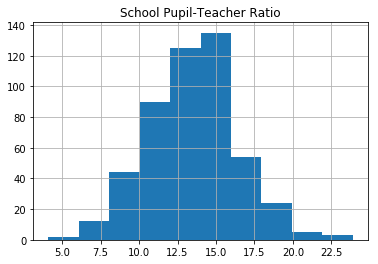

In [30]:
class_size_out_df.hist(column='School Pupil-Teacher Ratio')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10981de10>]], dtype=object)

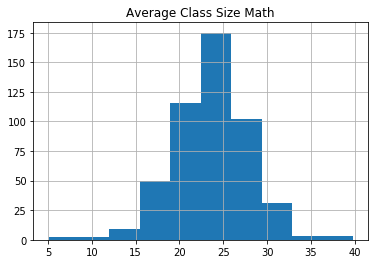

In [31]:
class_size_out_df.hist(column='Average Class Size Math')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10981d588>]], dtype=object)

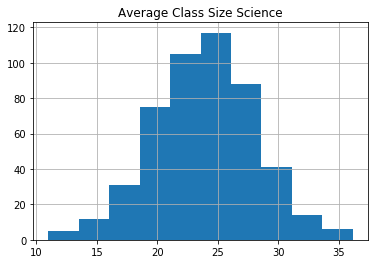

In [32]:
class_size_out_df.hist(column='Average Class Size Science')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1098bdcc0>]], dtype=object)

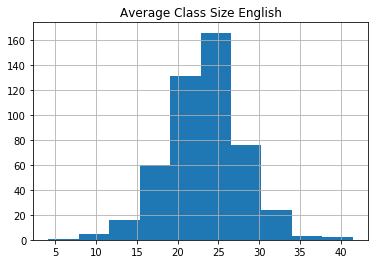

In [33]:
class_size_out_df.hist(column='Average Class Size English')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11209e2b0>]], dtype=object)

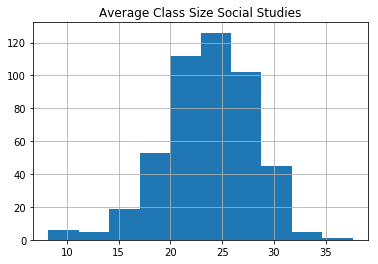

In [34]:
class_size_out_df.hist(column='Average Class Size Social Studies')

## Write the cleaned and flattened dataset to disk as a csv file

In [35]:
class_size_out_df.to_csv('class_size_cleaned.csv')


In [36]:
class_size_out_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494 entries, 01M034 to 32K562
Data columns (total 13 columns):
Number of Students English           484 non-null float64
Number of Students Math              493 non-null float64
Number of Students Science           494 non-null float64
Number of Students Social Studies    474 non-null float64
Number of Classes English            484 non-null float64
Number of Classes Math               493 non-null float64
Number of Classes Science            494 non-null float64
Number of Classes Social Studies     474 non-null float64
Average Class Size English           484 non-null float64
Average Class Size Math              493 non-null float64
Average Class Size Science           494 non-null float64
Average Class Size Social Studies    474 non-null float64
School Pupil-Teacher Ratio           494 non-null float64
dtypes: float64(13)
memory usage: 74.0+ KB


## Final observations about `class_size_cleaned.csv`

- we have data for 494 middle schools
- there are no duplicate entries (manually confirmed)
- we have pupil-teacher ratio for all schools
- we have avg science class size for all schools
- we are missing avg math class size for only one school
- we are missing avg English class size for 10 schools
- we are missing avg Social Studies class size for 20 schools
- all class size data and pupil-teacher ratio data are approximately normally distributed

If we assume schools keep class sizes pretty similar across subjects, then we could treat the avg science class size (100% complete data) as a proxy for the school's class size.  Since most of the specialized schools are STEM-focused, this also seems to be a not inappropriate reduction of dimensionality.